# Introduction

The world was taken by storm by generative models: ChatGPT, Llama, Mistral, Claude, Grok, and I could spend the next two weeks enumerating other models... But all of these seem to have a common denominator—the underlying transformer model. In this round, I wanted to take a stab at generating text! Since the previous dataset wasn't that big, I decided to move on to a much bigger one: M25 group chat.

# Introduction

The world was taken by storm by generative models: ChatGPT, Llama, Mistral, Claude, Grok, and I could spend the next two weeks enumerating other models... But all of these seem to have a common denominator—the underlying transformer model. In this round, I wanted to take a stab at generating text! Since the previous dataset wasn't that big, I decided to move on to a much bigger one: M25 group chat.  

# Data

Let's take a look at the gathered data.

## Size

In [1]:
import math

with open("input.txt", 'r') as f:
    data = f.read()

orders = math.log10(len(data))

Drum rolls please!

In [2]:
round(orders, 2)

6.91

We have slightly less than $10^7$ tokens in the gathered data, which will hopefully be enough to train an interesting model without overfitting it too much.

## Quality Control 🧑‍🍳

Okay, we have a lot of example, but let's see how good the data actually is!

In [3]:
import numpy as np

block_size = 50
n_examples = 5
idx = np.random.randint(0, len(data), (n_examples,))

for ix in idx:
    print(data[ix:ix+block_size])

f the world can afford it
They begin talking about
ho in
How productive would having two master procr
25x miles in every purchase, 5x for hotels and car
lation should decrease...
Okay
I don't remember an
mmended as ASM; I'm so sorry if it made things inc


Emojis, abbreviations, random characters at times—looks about right! This is probably not the best data to create a foundational model (who has compute for that anyways, ehh...), but it will be fun for a toy model.

# Converting to Python readable format

This step is quite simple since the data is collected in a single text file. We can just follow the steps above to read it from a file to a big big string.

# Pre-processing

## Cleaning up

Since this is a generative model that I will work on, I do not want to clean the data to keep all the quirkiness of a Minerva group chat. Therefore, the data will be used "as is."

## Encoding

### Motivation

Models usually work with numeric data rather than strings or characters. For this assignment, I wish to utilize the transformer architecture, which works with discrete tokens. Those tokens can be created in multiple different ways, such as word-level encoding (each word is a token), byte-pair encoding (widely used in the industry), or character-level (encoding), which is arguably the simplest one, and for that reason will be in this work.

### How it works?

The idea is quite simple—we treat each character as a "token." To do that, we find all possible characters—the vocabulary list—in the dataset and assign a unique value to each. Then, the strings are passed through that encoding, which becomes a big list of numbers instead of chars.

In [4]:
vocab = sorted(list(set(data)))
ch2ix = {ch:ix for ix, ch in enumerate(vocab)}
ix2ch = {ix:ch for ix, ch in enumerate(vocab)}

encode = lambda s: [ch2ix[ch] for ch in s]
decode = lambda t: ''.join([ix2ch[ix] for ix in t])

In [5]:
encoded_data = encode(data)
encoded_data[:10]

[78, 80, 84, 85, 1, 80, 71, 1, 85, 73]

As we can see, the data is now a list of numbers! We should also make sure the decoding works.

In [6]:
example = "some super long string with different characters!#$!@@!$#"

assert decode(encode(example)) == example
assert decode(encode('')) == ''
assert decode(encode(data[10_000:])) == data[10_000:]

It looks like it works!

# Task

## Description

The task is quite simple—generate text that looks like a text from the m25 group chat.

The task conceptually is trivial (I think), but the "how" is the hard part :), which we will dive into very soon.

## Train-test split

Since the dataset is quite big, and we want to use many examples for training (it is a generative model, after all), we will use 90% for training and 10% for validation. The model will be tested by generating new text and seeing how well it did (hopefully, we will be able to see some actual words...).

# Model

![Model](model.png)

## Motivation

Creating a generative model for text can be as hard and as simple as we make it. For example, a bi-gram model is a simple look-up table that predicts the probability of the next token given the previous token. We can improve on this model by using the n-gram model, which uses n-1 previous tokens to predict the next one. However, we can also go as far as implementing something like a state space model with HiPPOs, which uses a combination of signal processing, a clever way of encoding past information in latent space, and hardware optimizations, but we won't get into that yet...

For this assignment, I wanted to implement something effective yet relatively simple, so the choices were some kind of RNN (vanilla, LSTM, or GRU), convolutional model, such as wave net, or transformers. I went with the latter as I wanted to dig deeper into that architecture for a while; however, the others will be used for comparison.

## How does the transformer work?

### Embedding

Before processing the tokens, we want to give them semantical meaning. The transformer does that by embedding layers. It takes the list of tokens, which in our case are integers, as input and uses a look-up table to give `d' dimensional vectors back. It works a bit like an autoencoder because it can reduce the dimensionality of data (instead of having a list of one-hot encoded vectors for each example of vocabulary size, we reduce the dimension to the desired dimensions).

### Positional Encoding

As transformers are not recurrent models, there is no notion of time in the input, so we need to add it. We do that by creating a time vector. This is simply a vector from 0 to the length of input tokens. For example, if there are 3 tokens in the input, the time vector would be `[0, 1, 2]`. Then, those vectors are embedded in `d` dimensional space (similar to the tokens; note, however, that it's a map from a number of tokens to `d` dimensions rather than from vocabulary size to `d`). Lastly, they are added to the embedded tokens to give them a sense of time. 

Important note: both embedding tables are learned parameters in the model.

### Attention!

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q \, K^T}{\sqrt{d_k}}\right) \, V
$$

More precisely, scaled dot-product attention—the heart of the model. The idea behind it is so that the tokens can "communicate" with each other, which happens through calculating the compatibility score between the tokens.

![attention.png](attention.png)

At first, we use 3 different linear projections to create 3 vectors: key, query, and value that will represent "what I have," "what I am looking for," and the latent space of the token. The first two are used to calculate the weights, which we use for a weighted average of values vector (the softmax function is applied to normalize values to sum to 1). To illustrate what I mean by all this, I've trained a very small model with one attention block and visualized the weights before multiplied with $V$, i.e., $\text{softmax}\left(\frac{Q \, K^T}{\sqrt{d_k}}\right)$.

The corpus it was trained on was

```python
data = 'hello this is some simple dataset for a super small transformer'
```

**Untrained Model**

![untrained_attn.png](untrained_attn.png)

**Trained Model**

![trained_attn.png](trained_attn.png)

Note that the model has a decoder-only architecture in this example, and thus, the attention is causal (the model cannot see into the future, which is signified by the black pixels in the upper right part of the image).

As shown above, before the model was trained, the attention was distributed roughly equally amongst all the tokens. After training, however, the attention is more focused. When it sees a novel after another vowel (i.e., "o" after "e"), it focuses its attention on the previous vowel. Or, when it sees two consonants in a row, it focuses on the previous consonants to predict the next token. Neat!

![multihead.png](multihead.png)

Authors mentioned that they found that creating $n$ $\frac{d}{n}$ dimensional heads was beneficial to the model's performance as it allowed for the tokens to be attended from different learned linear projections at different positions.

$$
\text{MultiHeadAttention}(Q, K, V) = \text{Concat}(\text{Attention}(QW_i^Q, KW_i^K, VW_i^V))
$$
 
In code, all this is implemented using the same matrix multiplications for faster computation.

### MLP

After all the attention magic is done, we also apply a simple linear layer, followed by a non-linearity, which essentially is a multi-layer perceptron with a single hidden layer (in my implementation, it specifically has a size of 4 times the embedding dimensionality).

### GeLU vs ReLU

For the activation function, you might notice that I used GeLU instead of the more popular ReLU or Tanh. ReLU is usually preferred as Tanh struggles with the vanishing gradients problem (the gradient vanishing to exist after a couple of layers). This happens because the derivative of tanh is $1 - \text{tanh}^2(x)$, which has a range between 0 and 1, and more importantly, it has a narrow range, where its value is not close to 0 as shown on the plot below.

![tanh](tanh.png)

ReLU function is a step in the right direction as its range allows neurons to express more extreme opinions than in tanh because its inverse domain is from 0 to $\infty$; however, now a new problem arises. ReLU is not differentiable at 0 (not a huge problem; just assume the value of derivative 0 or 1). However, through research, people found that a smoother, non-monotonic activation function is better as it allows for capturing more complex relationships in data; thus, GeLU was born.

GeLU uses a cdf of a normal distribution to create a similar shape to ReLU while maintaining the differentiability and non-monotonic properties, resulting in improved performance.

![relu vs gelu](relu_vs_gelu.png)

### Layer Norm

Layer normalization stems from batch normalization. Batch normalization was first introduced by Ioffe & Szegedy (2015) to alleviate the problem of already mentioned exploding/vanishing gradients. The idea behind this was quite simple: calculate the mean and variance across the batch dimension. Then, the output that is scaled by a factor $\gamma$ and $\beta$ (both of which are learned parameters) is added to restore the representative power to the model.

$$
\hat{x}^{(k)} = \frac{x^{(k)} - \text{E}[x^{(k)}]}{\sqrt{\text{Var}[x^{(k)}]}}
$$

$$
y^{(k)} = \gamma^{(k)} \hat{x}^{(k)} + \beta^{(k)}
$$

where $x^{(k)}$ is a mini-batch sampled from the dataset, $\text{E}$ is the expected value, and $\text{Var}$ is the variance.

Introducing the batch normalization has been shown to improve the network's performance.

Layer normalization works exactly the same, but instead of normalizing on the batch dimension, it normalizes along the features. It seems that Layer Normalization is better suited for NLP as the size of the sequence can often differ, which requires different statistics for different time steps, according to Be et al. (2016).

### Residual Connection

![residual](residual.png)

Residual connection is the idea of adding an identity of the input to the output of the layer. The intuition behind it is that optimizing to find a value to fix the error (residual) is easier than fitting the bare unreferenced value (He et al., 2016). This idea is quite simple, yet improves learning; thus, it has been widely adopted.


### Dropout

![dropout](dropout.png)

Introduced by Srivastava et al. (2014), it is a method to prevent network overrelying on some neurons. Dropout deletes certain neurons with a probability $p$ at training, as shown on the right side of the image above. At inference, all neurons are utilized; however, the weights are scaled by the factor of $p$; for example, weights for $i$ th layer would be $W_i p$.

## Optimization

### RMSProp

Now that we have figured out how the transformer works let's dig deeper into optimizing its parameters. In the code, I used an optimizer called "AdamW." It builds up on a popular optimizer, Adam, which itself is a combination of RMSProp (an idea popularized by Geoffrey Hinton) and momentum. The prior technique scales the learning rate by a factor of squared gradients apart from the previous step. Mathematically, 

$$
\nabla f(\theta_{t-1}) = g_t
$$

where $f$ is the function, we optimize for (loss function), $\theta$ are the network's parameters, and $t$ is the time step.

$$
v_t = \beta_1 \cdot v_{t - 1} + (1 - \beta_1) \cdot g_t^2
$$

where $g_t^2$ is the gradient vector piece-wise multiplied with itself, $\beta$ is a decay factor, which is a hyperparameter, and $v_0 = 0$.

$$
\alpha_t = \frac{\alpha}{\sqrt{v_t} + \epsilon}
$$

where $\alpha$ is the base learning rate (a hyperparameter), $\alpha_t$ is the learning rate at time-step $t$, and $\epsilon$ is a small number to prevent division by zero.

While no formal paper introduces this method, the intuition behind it is quite simple. We want to "dampen" the learning rate when the gradients grow. On the other hand, when we are in the flat regions of the gradient, we want to increase the optimizer's learning rate (step size). This happens because we divide the learning rate by a factor of $v_t$, directly and linearly related to the gradient. Note that $v_t$ is a vector, so each parameter's learning rate is adapted.

### Momentum

Momentum is a technique that prevents the model from getting stuck in local minima. The idea is to keep track of previous gradients and decay them over time. Mathematically,

$$
m_t = m_{t-1} \cdot \beta_2 + g_t \cdot (1 - \beta_2)
$$

where $m_t$ is the momentum term for time step $t$, and $\beta_2$ is a hyperparameter. Then, $m_t$ is used to adjust the learning rate:

$$
\alpha_t = \alpha \cdot m_t
$$

### Adam

Putting it together, we get Adam, a combination of RMSProp and Momentum. Then, the learning rate is determined as follows

$$
\alpha_t = \frac{\alpha \cdot m_t}{{\sqrt{v_t} + \epsilon}}
$$

In the code implementation, we also divide the $v_t$ and $m_t$ by $1 - \beta_1^t$ and $1 - \beta_2^t$, respectively, to reduce the bias.

### AdamW

AdamW is, as the name might suggest, Adam with decoupled Weight decay, which acts as a type of normalization. As mentioned in Loshchilov & Hutter (2019), simple L2 or L1 norm is less effective in the case of Adam because the gradient is scaled anyway due to the RMSProp term. Mathematically, those norms would be expressed in the $g_t$ term.

$$
g_t = \nabla f(\theta_{t-1}) + \lambda \theta_{t - 1}
$$

Loshchilov & Hutter (2019) suggest that using decoupled weight decay, which is added to the update term at the end, leads to better results.

$$
\alpha_t = \alpha \cdot \left(\frac{m_t}{{\sqrt{v_t} + \epsilon}} + \lambda \theta_{t - 1}\right)
$$

All other steps follow from the original version of Adam. Also note that, in the paper, they also suggest that using a learning rate schedule helps to improve performance, and cosine annealing has proved to be the most successful. We will use that fact when implementing the training loop of the final architecture. Below, I implemented an AdamW from scratch and compared it to the Pytorch on a simple MLP for XOR.

In [7]:
import torch
import torch.nn.functional as F

n_in = 2
n_hidden = 4
n_out = 1

W1 = torch.rand(2, n_hidden, requires_grad=True)
b1 = torch.rand(n_hidden, requires_grad=True)
W2 = torch.rand(n_hidden, 1, requires_grad=True)
b2 = torch.rand(1, requires_grad=True)
params = [W1, b1, W2, b2]

def MLP(params, X, y=None):
    W1, b1, W2, b2 = params
    logits = F.relu(X @ W1 + b1) @ W2 + b2
    logits = logits.squeeze()

    if y is not None:
        # Binary cross entropy
        probs = F.sigmoid(logits)
        loss = -((1 - y) * torch.log(1 - probs) + y * torch.log(probs)).mean()
    else:
        loss = None

    return logits, loss

class AdamW:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01):
        self.params = params
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.t = 0
        self.state = {
            "m": [0 for _ in self.params],
            "v": [0 for _ in self.params],
        }
    def step(self):
        '''Takes a step of an optimizer'''
        self.t += 1
        b1, b2 = self.betas

        for ix, p in enumerate(self.params):
            gt = p.grad
            # Calculate the v and m for rmsprop and momentum
            mt = b1 * self.state['m'][ix] + (1 - b1) * gt
            vt = b2 * self.state['v'][ix] + (1 - b2) * gt.square() 
            # Correct for bias
            mt /= (1 - b1**self.t)
            vt /= (1 - b2**self.t)
            # Calculate the update term
            update = mt / (vt.sqrt() + self.eps) + self.weight_decay * p.data
            # Update the parameters
            p.data -= update * self.lr
            # Update the internal state of optimizer
            self.state['m'][ix] = mt
            self.state['v'][ix] = vt
            
    def zero_grad(self):
        '''Zeros out the gradients on parameters'''
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


X = torch.randint(0, 2, (128, 2))
y = X[:, 0] ^ X[:, 1]
X = X.float()

In [8]:
lr = 1e-2
epochs = 1000

torch_opt = torch.optim.AdamW(params, lr=lr)
opt = AdamW(params, lr=lr)

torch_losses = []
my_losses = []

for _ in range(epochs):
    for t in ['torch', 'mine']:
        optimizer =  opt if t == 'mine' else torch_opt
        params = torch_opt.param_groups[0]['params'] if t == 'torch' else opt.params

        _, loss = MLP(params, X, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if t == 'torch': torch_losses.append(loss.item())
        else: my_losses.append(loss.item())

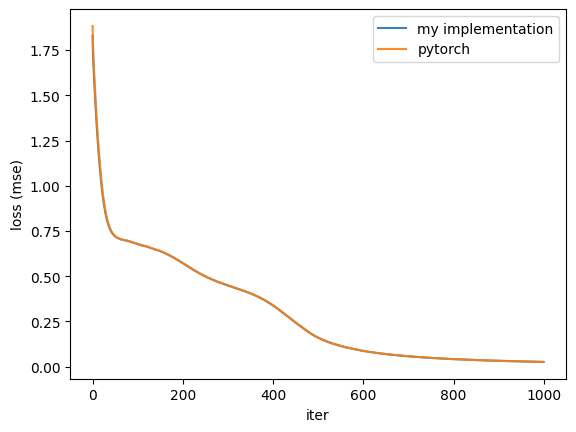

In [9]:
import matplotlib.pyplot as plt

plt.plot(my_losses, label='my implementation', alpha=0.9)
plt.plot(torch_losses, label='pytorch', alpha=0.9)
plt.ylabel("loss (mse)")
plt.xlabel("iter")
plt.legend()
plt.show()

In [10]:
zz = F.sigmoid(MLP(params, torch.tensor([[0, 0]]).float())[0]).round().item()
zo = F.sigmoid(MLP(params, torch.tensor([[0, 1]]).float())[0]).round().item()
oz = F.sigmoid(MLP(params, torch.tensor([[1, 0]]).float())[0]).round().item()
oo = F.sigmoid(MLP(params, torch.tensor([[1, 1]]).float())[0]).round().item()

assert (zz, zo, oz, oo) == (0., 1., 1., 0.)

Looks like this implementation follows the Pytorch's version pretty well :)

Note that this implementation will not be used for the actual model as the Pytorch version has a similar API, yet introduces kernel-level optimizations; thus, it will be used instead.

## Putting it all together

### Forward Pass (step 1)

The first step to optimizing the model is calculating the forward pass. It uses existing weights, which at first are intialized randomly, to calculate the logits for the next token given the history. The model would use the transformer architecture described above.

### Calculate Loss (step 2)

The next step is calculating the loss function, with respect to which the model is optimized. Since this is a classification problem—"what is the next token in the sequence"—cross entropy is used.

$$
H\left(P^*, P\right) = -\sum_{i=1}^{\text{Vocabulary Size}} P^*(w_i) \cdot \log{P(w_i)}
$$

where $P^*$ is the true probability distribution of words, $P$ is predicted distribution (from the model), and $w_i$ is $i$ th word in the vocabulary.

### Backward Pass (step 3)

Lastly, partial derivatives of loss function w.r.t. each parameter of the model is calculated to update the weights as prescribed in the previously described AdamW optimizer. Then, this process is repeated for number of iterations to achieve desired loss level.

# Training Model

This one will take a while...

In [11]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        # Make sure the n_heads
        assert config['n_embed'] % config['n_heads'] == 0

        self.n_heads = config['n_heads']
        self.head_size = config['head_size']
        self.c_attn = nn.Linear(config['n_embed'], config['n_embed'] * 3)
        self.c_proj = nn.Linear(config['n_embed'], config['n_embed'])

        self.attn_dropout = nn.Dropout(config['dropout'])
        self.res_dropout = nn.Dropout(config['dropout'])

        self.device = config['device']

    def forward(self, x):
        # Get matrix shape
        # B --> Batch
        # T --> Time
        # C --> Channels
        B, T, C = x.size()
        
        # Use linear projection to 
        # create key, query, value vectors

        x = self.c_attn(x) # B T C --> B T 3C
        q, k, v = x.split(C, dim=2) # Each is B T C
        
        # For multihead attention we want parralelize computation for each head
        # Therefore, we move the Time dimension to the second to last position
        # Which is going to result in (B nh T hs) @ (B nh hs T) --> (B nh T T)
        # It works because PyTorch performs the matmul on the right side 
        # And each is applied in parrallel across all other dimensions

        q = q.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2) # B T nh, hs --> B nh T hs
        k = k.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2) # B T nh, hs --> B nh T hs
        v = v.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2) # B T nh, hs --> B nh T hs
        
        # Multihead self causal attention

        wei = q @ k.transpose(-1, -2) / (torch.tensor(self.head_size).sqrt()) # B nh T hs @ B nh hs T --> B nh T T
        # Create a mask for causal attention
        # Creates a lower triangular matrix
        tril = torch.tril(torch.ones(T, T)).to(self.device)
        # Mask all "future" tokens by changing its value to -inf
        # Which will be scaled to 0 after softmax
        wei = wei.masked_fill(tril == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        # Apply dropout if specified
        wei = self.attn_dropout(wei)
        # Calculate the attention 
        attn = wei @ v # B nh T T @ B nh T hs --> B nh T hs
        # Go back to (B T nh hs) shape
        attn = attn.transpose(1, 2) # B nh T hs --> B T nh hs
        # Reshape to original shape
        attn = attn.contiguous().view(B, T, C)
        # Apply linear projection for final value
        # and dropout if specified
        y = self.res_dropout(self.c_proj(attn))

        return y

class MLP(nn.Module):
    '''Simple MLP module'''
    def __init__(self, config):
        super().__init__()
        # Linear projection
        self.c_fc    = nn.Linear(config['n_embed'], 4 * config['n_embed'])
        # GELU (a variation of RELU)
        # It uses Gaussian CDF rather than max
        # to create the non-linearity
        # gelu(x) = norm_cdf(x) * x
        # which is usually approximated to 
        # tanh(sqrt(2pi) * (x + x^3 * 0.44715))
        # for computational efficiency
        self.gelu    = nn.GELU()
        # Another linear projection
        self.c_proj  = nn.Linear(4 * config['n_embed'], config['n_embed'])
        # Dropout if specified
        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, x):
        '''Defines __call__ behaviour in PyTorch'''
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    '''Transformer block'''
    def __init__(self, config):
        super().__init__()
        # Use layer normalization for reducing the problem of 
        # vanishing/exploding gradients in deep neural network architectures
        # In short, it takes the mean and std of all dimensions except batch
        # and normalizes by substracting mean and dividing by std
        self.ln_1 = nn.LayerNorm(config['n_embed'])
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config['n_embed'])
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
    
class SimpleLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Make sure vocab size and block size are specified
        assert config['vocab_size'] is not None
        assert config['block_size'] is not None
        # Create positional and token embeddings
        self.embd     = nn.Embedding(config['vocab_size'], config['n_embed'])
        self.pos_embd = nn.Embedding(config['block_size'], config['n_embed'])
        # Attention blocks
        self.transformers = nn.ModuleList(
            Block(config) for _ in range(config['n_layers'])
        )
        self.fc = nn.Linear(config['n_embed'], config['vocab_size'])
        self.device = config['device']

    def forward(self, x, target=None):
        '''
        Runs forward pass for the simple language model
        ---
        Parameters:
          - x: torch.tensor for sample data
          - targets: torch.tensor for target labels
        ---
        Returns:
          - logits: torch.tensor logits for the sampled data
          - loss: float cross entropy loss for target labels
        '''
        B, T = x.size()
        if target is not None:
            # Make sure the targets have desired shape
            assert target.shape[0] == B
        # Create time tensor
        t = torch.arange(T).to(self.device)

        # Embed tokens and time
        x   = self.embd(x)
        pos = self.pos_embd(t)
        # Add positional embeddings
        x += pos

        for transformer in self.transformers:
            x = transformer(x)
        logits = self.fc(x)

        if target is None:
            logits = logits[:, -1, :]
            loss = None
            return logits, loss
        # logits --> B T Vocab --> B*T Vocab; dim = 2
        # target --> B T       --> B*T      ; dim = 1
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target.view(-1))

        return logits, loss

In [12]:
config = dict(
    # Model
    block_size = 256,
    batch_size = 8,
    head_size = 32,
    n_embed = 256,
    n_layers = 8,
    n_heads = 8,
    dropout = 0.1,
    
    # Optimization
    lr = 1e-3,
    min_lr = 1e-4,
    lr_decay_iters = 5000,

    beta1 = 0.9,
    beta2 = 0.99,

    # Training
    train_size = 0.9,
    max_iter = 5000,
    eval_interval = 100,
    eval_iters = 10,

    device = 'mps', # for training on macbook with m chips
)

In [13]:
from tqdm import tqdm

# Load data from file
with open('input.txt', 'r') as f:
    data = f.read()

# Char-level vocabulary
vocab = sorted(list(set(data)))
vocab_size = len(vocab)
config['vocab_size'] = vocab_size 

# Simple char level tokenizer 
ch2ix = {ch:ix for ix, ch in enumerate(vocab)}
ix2ch = {ix:ch for ix, ch in enumerate(vocab)}

encode = lambda s: [ch2ix[ch] for ch in s]
decode = lambda t: ''.join([ix2ch[ix] for ix in t])

def make_dataset(data):
    # Store examples and targets
    data = np.array(encode(data))
    n = len(data) - config['block_size'] - 1
    X, y = [None] * n, [None] * n

    for ix in tqdm(range(n)):
        # Sequence of chars
        X[ix] = data[ix:ix+config['block_size']]
        # Sequence of chars shifted to the right in time dimension 
        # (prdictions from previous) inputs
        y[ix] = data[ix+1:ix+1+config['block_size']]

    return np.array(X), np.array(y)


def split_data(X, y, train_size: float = 0.9):
    n = len(X)
    n_split = int(n * train_size)
    Xtr, ytr, Xval, yval = X[:n_split], y[:n_split], X[n_split:], y[n_split:]

    return Xtr, ytr, Xval, yval

class DataLoader:
    def __init__(self, X, y, batch_size, train_val_split=True, train_size: float = 0.9, device='cpu'):
        self.X = X
        self.y = y
        self.batch_size = batch_size

        if train_val_split:
            self.Xtr, self.ytr, self.Xval, self.yval = split_data(self.X, self.y, train_size)
            
        self.ix = 0
        self.device = device
    
    def __iter__(self):
        for ix in range(0, len(self.X), self.batch_size):
            yield self.X[ix:ix+self.batch_size], self.y[ix:ix+self.batch_size]

    def get_batch(self, split):
        if split not in ['train', 'val']:
            raise ValueError(f"{split} not available. `train` and `val` can only be chosen")
        X, y = (self.Xtr, self.ytr) if split == 'train' else (self.Xval, self.yval)
        n = len(X)
        idx = np.random.randint(0, n, (self.batch_size, ))

        return torch.tensor(X[idx]).to(self.device), torch.tensor(y[idx]).to(self.device)
    

@torch.no_grad()
def esimate_loss(model, data_loader, eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for ix in range(eval_iters):
            X, y = data_loader.get_batch(split)
            _, loss, *_ = model(X, y)
            losses[ix] = loss.item()
        out[split] = losses.mean()
    return out

def generate(model, prompt, max_tokens = 256, temperature = 1):
    model.eval()
    X = encode(prompt)
    X = torch.tensor(X).unsqueeze(0).to(config['device'])
    generated = []
    for _ in range(max_tokens):
        logits, _ = model(X)
        logits /= temperature
        ch = torch.distributions.Categorical(logits=logits).sample()
        generated.append(ch.item())
        X = torch.cat((X, ch.unsqueeze(0)), dim=1)
        X = X[:, -config['block_size']:]

    return decode(generated)

def get_lr(iter):
    if iter >= config['lr_decay_iters']:
        return config['min_lr']
    # apply cosine annealing
    coeff = 0.5 * (config['lr'] - config['min_lr']) * (1 + np.cos(iter / config['lr_decay_iters'] * np.pi))
    return config['min_lr'] + coeff

def change_lr(opt, lr):
    for g in opt.param_groups:
        g['lr'] = lr

def save_state(iter, _model, opt, name):
    checkpoint = { 
    'iter': iter,
    'model': _model.state_dict(),
    'optimizer': opt.state_dict(),
    }

    torch.save(checkpoint, f'{name}.pth')

In [14]:
n = len(data)
X, y = make_dataset(data)
dl = DataLoader(X, y, batch_size=config['batch_size'], device=config['device'])

100%|██████████| 8084782/8084782 [00:02<00:00, 3087532.83it/s]


In [15]:
model = SimpleLM(config).to(config['device'])
opt = torch.optim.AdamW(model.parameters(), lr=config['lr'], betas=(config['beta1'], config['beta2']))

In [16]:
best_val_loss = float('inf')
train_loss = []
val_loss   = []

for iter in range(config['max_iter']):
    X, y = dl.get_batch('train')
    model.train()
    _, loss = model(X, y)
    loss.backward()
    opt.step()

    if (iter + 1) % config['eval_interval'] == 0:
        loss = esimate_loss(model, dl, config['eval_iters'])
        # Record loss
        train_loss.append(loss['train'])
        val_loss.append(loss['val'])

        if loss['val'] < best_val_loss:
            best_val_loss = loss['val']
            save_state(iter, model, opt, 'transformer')
        print(f"iter {iter + 1}: train loss = {loss['train']}; val loss = {loss['val']}")

    opt.zero_grad()
    change_lr(opt, get_lr(iter))

iter 100: train loss = 2.8140060901641846; val loss = 2.807687759399414
iter 200: train loss = 2.691852331161499; val loss = 2.822800397872925
iter 300: train loss = 2.716904401779175; val loss = 2.709624767303467
iter 400: train loss = 2.683680534362793; val loss = 2.7087230682373047
iter 500: train loss = 2.486873149871826; val loss = 2.5071020126342773
iter 600: train loss = 2.3272597789764404; val loss = 2.336305618286133
iter 700: train loss = 2.2417984008789062; val loss = 2.261887788772583
iter 800: train loss = 2.1161322593688965; val loss = 2.2167775630950928
iter 900: train loss = 2.0628905296325684; val loss = 2.1475887298583984
iter 1000: train loss = 2.0340991020202637; val loss = 2.0195159912109375
iter 1100: train loss = 1.8618907928466797; val loss = 1.9537956714630127
iter 1200: train loss = 1.8706576824188232; val loss = 1.93656325340271
iter 1300: train loss = 1.87666916847229; val loss = 1.8903062343597412
iter 1400: train loss = 1.802025556564331; val loss = 1.8327

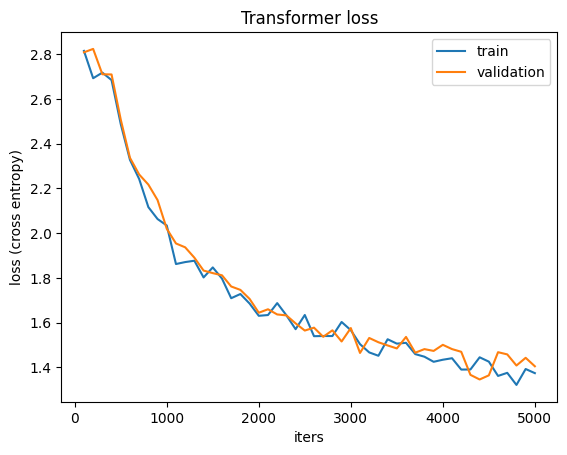

In [17]:
iters = np.arange(len(train_loss)) * config['eval_interval'] + 100
plt.plot(iters, train_loss, label='train')
plt.plot(iters, val_loss,   label='validation')
plt.xlabel("iters")
plt.ylabel("loss (cross entropy)")
plt.legend()
plt.title('Transformer loss')
plt.show()

The loss has a nice curve; there is not much discrepancy between the validation and train, which is a good sign that model did not overfit.

# Out of Sample Predictions and Performance

To evaluate the model, we will look at the output (is it total gibberish?), and the cross entropy on a sampled part from the dataset (since the whole test set is too big).

## Generation

In [19]:
# Load the state with the lowest validation loss and generate text using it
chkpt = torch.load('transformer.pth', map_location='cpu')
best_model = SimpleLM(config)
best_model.load_state_dict(chkpt['model'])
config['device'] = 'cpu'
print(generate(best_model, '\n', temperature=0.8, max_tokens=1024))

The booked of the overpoor one communal work or a meet I forgot assigned questions about 5-5 pm to be a dates Form - design the too part on you to do for it
Wi anyone have to enter the SSN to the being different their medical call on people!!! Does anyone have a PART of anybody resources in SF? We are interested in of the res. We would have a good station as welcome to the airport to hear that they are there are welcome that ✌️
this is the best one their few to the SSN cute because the create in the callendar time and exchanged the announcement lol and personal rate of yours, they are one will be able to this minerva for online. If you can do not sure emails anyone wants to stay a new passport on CS year collations on the support seriously for that are we can receive anything the break that manager has speakers on the brade in the world. I just missically am all in the looking, it was just card after this one one that I think it’s probably forms working. They don’t really noteve on the

The text looks very similar to the groupchat. However, the closer you look, the more nonsense you realize is in there; it's fascinating!!

## Cross Entropy

In [20]:
esimate_loss(model, dl, 1000) # calculate loss for 1000 mini-batches to get a good estimate

{'train': tensor(1.4045), 'val': tensor(1.4191)}

## LSTM Comparison

In [21]:
class LSTMLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb = nn.Embedding(config['vocab_size'], config['n_embed'])
        self.ln = nn.LayerNorm(config['n_embed'])
        self.lstm = nn.LSTM(config['n_embed'], config['n_embed'], batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Sequential(
            nn.Linear(config['n_embed'], 4 * config['n_embed']),
            nn.GELU(), 
            nn.Linear(4 * config['n_embed'], config['vocab_size']),
        )

    def forward(self, x, target=None, hidden=None):
        emb = self.emb(x)
        emb = self.ln(emb)

        out, _ = self.lstm(emb)
        # residual connection with dropout
        res = emb + self.dropout(out)
        # fully connected layer
        logits = self.fc(res) # B T vocab


        if target is not None:
            # target --> B T       -transformed-> B*T
            target = target.view(-1)
            # logits --> B T vocab -transformed-> B*T vocab
            logits = logits.view(-1, logits.size(-1))
            # calculate loss
            loss = F.cross_entropy(logits, target)
        else: 
            loss = None
            logits = logits[:, -1, :]

        return logits, loss

In [22]:
config['device'] = 'mps'

lstmLM = LSTMLM(config).to(config['device'])
opt = torch.optim.AdamW(lstmLM.parameters(), lr=config['lr'], betas=(config['beta1'], config['beta2']))

In [23]:
best_val_loss = float('inf')
lstm_train_loss = []
lstm_val_loss   = []

for iter in range(config['max_iter']):
    X, y = dl.get_batch('train')
    lstmLM.train()
    _, loss = lstmLM(X, y)
    loss.backward()
    opt.step()

    if (iter + 1) % config['eval_interval'] == 0:
        loss = esimate_loss(lstmLM, dl, config['eval_iters'])
        # Record loss
        lstm_train_loss.append(loss['train'])
        lstm_val_loss.append(loss['val'])

        if loss['val'] < best_val_loss:
            best_val_loss = loss['val']
            save_state(iter, lstmLM, opt, 'lstm')
        print(f"iter {iter + 1}: train loss = {loss['train']}; val loss = {loss['val']}")

    opt.zero_grad()
    change_lr(opt, get_lr(iter))

iter 100: train loss = 2.598784923553467; val loss = 2.6107468605041504
iter 200: train loss = 2.2814817428588867; val loss = 2.2853264808654785
iter 300: train loss = 2.0714871883392334; val loss = 2.195315361022949
iter 400: train loss = 1.9997695684432983; val loss = 2.024775743484497
iter 500: train loss = 1.9598939418792725; val loss = 1.994227647781372
iter 600: train loss = 1.8961174488067627; val loss = 1.977855920791626
iter 700: train loss = 1.8261398077011108; val loss = 1.971758484840393
iter 800: train loss = 1.8206894397735596; val loss = 1.9056962728500366
iter 900: train loss = 1.7611370086669922; val loss = 1.8845469951629639
iter 1000: train loss = 1.7743160724639893; val loss = 1.8691227436065674
iter 1100: train loss = 1.732492446899414; val loss = 1.7947782278060913
iter 1200: train loss = 1.7681185007095337; val loss = 1.7898895740509033
iter 1300: train loss = 1.6937888860702515; val loss = 1.7548900842666626
iter 1400: train loss = 1.6634886264801025; val loss =

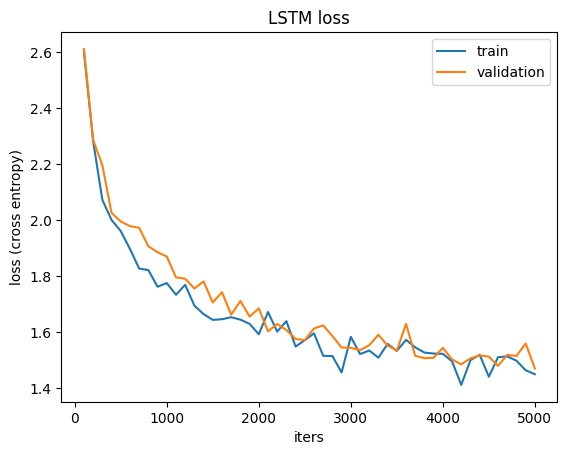

In [24]:
iters = np.arange(len(train_loss)) * config['eval_interval'] + 100
plt.plot(iters, lstm_train_loss, label='train')
plt.plot(iters, lstm_val_loss,   label='validation')
plt.xlabel("iters")
plt.ylabel("loss (cross entropy)")
plt.legend()
plt.title('LSTM loss')
plt.show()

Similarily to the transformer architecture, the loss seem to converge quite nicely together, which makes us confident that the model did not overfit.

In [25]:
# LSTMs can have infinite context, so the function was modified 
# to remove the part where we cut the input to context length

# Note: this function could be greatly improved for performance by 
# storing the hidden state from the LSTM layer if one were to deploy
# this model in practice; similarily to what is done with KV cache 
# in transformer-based architectures

def generate_lstm(model, prompt, max_tokens = 256, temperature = 1):
    model.eval()
    X = encode(prompt)
    X = torch.tensor(X).unsqueeze(0).to(config['device'])
    generated = []
    h, c = (None, None)

    for _ in range(max_tokens):
        logits, _ = model(X, hidden=(h, c))
        logits /= temperature

        ch = torch.distributions.Categorical(logits=logits).sample()
        generated.append(ch.item())
        X = torch.cat((X, ch.unsqueeze(0)), dim=1)

    return decode(generated)

## Text Generation

### LSTM

In [26]:
# Load the state with the lowest validation loss and generate text using it
chkpt = torch.load('lstm.pth', map_location='cpu')
best_model = LSTMLM(config)
best_model.load_state_dict(chkpt['model'])
config['device'] = 'cpu'
print(generate_lstm(best_model, ' ', temperature=0.8, max_tokens=1024))

is it anyone in the making is more and learning the Taiwanese card if you can get a hours
Played
Yeah thank you i take any countries and we want
I did someone wanna need to take my good and I have a since to study country with those to be at this arrival the food about Arazina/here because we can change the portal or minerva mentioned carified. If we need to take that moment (it sending on ends by. Feel Gama
We are just enter a whole bro school bick stript and take an emplain at our LBA target graph. The professes, and get out to go it
Plana ed and on my higher, so it's just will be back 3 must always now it was sent up with the F1 lateraph airport so I know what is the week that they want it to 1 team or minerva just need to are seems something we can do other but you want to depend a little of money then.
I want to do any vancial access to the first office
It's a long in a common to the same to leave so so international section as well
Hey guys I think you would not have an Mart!!!!!

### Transformer

In [27]:
# Load the state with the lowest validation loss and generate text using it
chkpt = torch.load('transformer.pth', map_location='cpu')
best_model = SimpleLM(config)
best_model.load_state_dict(chkpt['model'])
config['device'] = 'cpu'
print(generate(best_model, ' ', temperature=0.8, max_tokens=1024))

more
Say that the IL can the spile on the passports computer?
Wtfg why the cultures to credit for the left around their floor on the student student feest to sf votes that we can get here
Do not mean that with a person is, for the only backmark us to use those entires and where study?
Hi! I am arrival, sometimes in the application to this pay for a lot of the airport form in the good party to walk pay
is it like a company
I think u don't try to the second it until hall at their possible all of people will let out it too in a world common so the learning to provide is an experience financial from 9th payments or 3 days but the post.
nope of them someone’s good restructions for me to spell the first of the form on all with experience so success for trador is at least and something might alright busidey in the message of the past the says at the 2nd floor if you have from this form, people what it understand posts and the cuts you reading a scary to show much like they would orders to per

## Loss

In [28]:
transformer_loss = esimate_loss(model,  dl, 1000) # calculate loss for 1000 mini-batches
lstm_loss        = esimate_loss(lstmLM, dl, 1000) # calculate loss for 1000 mini-batches

print(f"tranformer loss = {transformer_loss['val']}; lstm loss = {lstm_loss['val']}")

tranformer loss = 1.411583662033081; lstm loss = 1.498284935951233


As shown above, the transformer-based architecture achieves superior loss, but at much higher computational costs (roughly 3x training time on my machine as an example).

# Executive Summary

![Pipeline](pipeline.png)

In this work, I used data from an M25 group chat to train a generative text model. I discussed and built the transformer architecture with a character-based tokenizer and compared it to the LSTM architecture. Empirically, we showed that the transformer achieved a lower loss (cross-entropy) with a difference of ~0.1 but was much slower to train.

The text from both models is not complete gibberish (which is fantastic). Still, it also does not sound believable, likely due to a relatively small dataset for the task and a poor tokenization method. 

In future work, I look forward to exploring better tokenization techniques, pre-training the model on a more extensive corpus of data (or using an open-sourced model as the base and fine-tuning that). 

# References

“Adam — PyTorch 2.0 Documentation.” Pytorch.org, pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam.

“AdamW — PyTorch 2.2 Documentation.” Pytorch.org, pytorch.org/docs/stable/generated/torch.optim.AdamW.html#torch.optim.AdamW. Accessed 25 Mar. 2024.
Ba, Jimmy Lei, et al. “Layer Normalization.” ArXiv:1607.06450 [Cs, Stat], 21 July 2016, arxiv.org/abs/1607.06450.

Andrej Karpathy. “NanoGPT.” GitHub, 24 Apr. 2023, github.com/karpathy/nanoGPT.

Brownlee, Jason. “Code Adam Optimization Algorithm from Scratch.” Machine Learning Mastery, 12 Jan. 2021, machinelearningmastery.com/adam-optimization-from-scratch/.

“Can the Vanishing Gradient Problem Be Solved by Multiplying the Input of Tanh with a Coefficient?” Data Science Stack Exchange, datascience.stackexchange.com/questions/51545/can-the-vanishing-gradient-problem-be-solved-by-multiplying-the-input-of-tanh-wi. Accessed 25 Mar. 2024.

Doshi, Ketan. “Transformers Explained Visually (Part 2): How It Works, Step-By-Step.” Medium, 3 June 2021, towardsdatascience.com/transformers-explained-visually-part-2-how-it-works-step-by-step-b49fa4a64f34.

Enozeren. “Word2Vec from Scratch with Python.” Medium, 15 Jan. 2024, medium.com/@enozeren/word2vec-from-scratch-with-python-1bba88d9f221. Accessed 25 Mar. 2024.
He, Kaiming, et al. “Deep Residual Learning for Image Recognition.” ArXiv.org, 10 Dec. 2015, arxiv.org/abs/1512.03385.

Kingma, Diederik P, and Jimmy Ba. “Adam: A Method for Stochastic Optimization.” ArXiv.org, 22 Dec. 2014, arxiv.org/abs/1412.6980.

“LayerNorm — PyTorch 1.13 Documentation.” Pytorch.org, pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html.

Loshchilov, Ilya, and Frank Hutter. “Decoupled Weight Decay Regularization.” Arxiv.org, 14 Nov. 2017, arxiv.org/abs/1711.05101.

“SGDR: Stochastic Gradient Descent with Warm Restarts.” ArXiv.org, 2016, arxiv.org/abs/1608.03983.

“Openai/Gpt-2.” GitHub, github.com/openai/gpt-2/blob/master/src/model.py#L141. Accessed 25 Mar. 2024.

“Papers with Code - Layer Normalization Explained.” Paperswithcode.com, paperswithcode.com/method/layer-normalization. Accessed 25 Mar. 2024.

“Regularization for Simplicity: L2 Regularization.” Google Developers, developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization.

“RMSProp.” DeepAI, 17 May 2019, deepai.org/machine-learning-glossary-and-terms/rmsprop#:~:text=RMSProp%2C%20which%20stands%20for%20Root.
Sergey Ioffe, and Christian Szegedy. 

“Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift.” PMLR, June 2015, pp. 448–456, proceedings.mlr.press/v37/ioffe15.html.

Srivastava, Nitish, et al. “Dropout: A Simple Way to Prevent Neural Networks from Overfitting.” Journal of Machine Learning Research, vol. 15, no. 56, 2014, pp. 1929–1958, jmlr.org/papers/v15/srivastava14a.html.

Vaswani, Ashish, et al. “Attention Is All You Need.” ArXiv.org, 12 June 2017, arxiv.org/abs/1706.03762.

“What Exactly Are Keys, Queries, and Values in Attention Mechanisms?” Cross Validated, stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms#:~:text=Queries%20is%20a%20set%20of. Accessed 25 Mar. 2024.

“Zero Grad on Single Parameter.” PyTorch Forums, 17 Mar. 2019, discuss.pytorch.org/t/zero-grad-on-single-parameter/40098. Accessed 25 Mar. 2024.
